#### Olivetti Face 数据集神经网络训练

In [43]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from sklearn.datasets import fetch_olivetti_faces
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

#### 数据加载

In [ ]:
# 1️、下载 Olivetti Faces 数据集
data = fetch_olivetti_faces(data_home='./face_data', shuffle=True)
images = data.images  # 图像数据 (400, 64, 64)
targets = data.target # 标签数据 (400,)

# 2️、归一化 (Olivetti 本身已经归一化到 0-1, 但可以调整到 -1 ~ 1 以适应 Tanh/BatchNorm)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  
])

# 3️、处理数据形状
X = images.reshape(-1, 1, 64, 64)  # (400, 1, 64, 64)  => 单通道灰度图
y = targets                         # 标签 0 ~ 39（共 40 个人，每人 10 张）

# 4️、训练集 & 测试集拆分
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5️、转换为张量
X_train, y_train = torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long)
X_test, y_test = torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long)

# 6️、封装为 DataLoader
BATCH_SIZE = 32
train_ds = TensorDataset(X_train, y_train)
test_ds = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE)

#### 构建神经网络

In [48]:
class FaceRecognitionNN(nn.Module):
    def __init__(self):
        super(FaceRecognitionNN, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),  # (1, 64, 64) -> (4096,)
            nn.Linear(64*64, 512),
            nn.BatchNorm1d(512),
            nn.Sigmoid(),
            nn.Dropout(0.3),
            
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.Sigmoid(),
            nn.Dropout(0.3),
            
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.Sigmoid(),
            
            nn.Linear(128, 40)  # 40 类
        )
    
    def forward(self, x):
        return self.model(x)

# **实例化模型**
model = FaceRecognitionNN()


#### 尝试不同优化器

In [49]:
# **交叉熵损失函数**
loss_fn = nn.CrossEntropyLoss()

# **不同优化器**
optimizers = {
    "SGD": optim.SGD(model.parameters(), lr=0.01, momentum=0.9),
    "Adam": optim.Adam(model.parameters(), lr=0.001),
    "RMSprop": optim.RMSprop(model.parameters(), lr=0.001)
}


#### 训练过程

In [51]:
def train_and_evaluate(optimizer_name, optimizer):
    model.train()
    epochs = 20
    loss_history = []

    for epoch in range(epochs):
        total_loss = 0
        for data, target in train_loader:
            data = data.view(data.size(0), -1)  # 展平成一维

            optimizer.zero_grad()
            output = model(data)
            loss = loss_fn(output, target)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        loss_history.append(avg_loss)
        print(f"Optimizer: {optimizer_name} | Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")
    
    return loss_history


#### 运行训练并观察 loss


🔹 Training with SGD Optimizer
Optimizer: SGD | Epoch [1/20], Loss: 3.7030
Optimizer: SGD | Epoch [2/20], Loss: 3.5813
Optimizer: SGD | Epoch [3/20], Loss: 3.5200
Optimizer: SGD | Epoch [4/20], Loss: 3.4460
Optimizer: SGD | Epoch [5/20], Loss: 3.3628
Optimizer: SGD | Epoch [6/20], Loss: 3.3166
Optimizer: SGD | Epoch [7/20], Loss: 3.2531
Optimizer: SGD | Epoch [8/20], Loss: 3.1954
Optimizer: SGD | Epoch [9/20], Loss: 3.1296
Optimizer: SGD | Epoch [10/20], Loss: 3.0712
Optimizer: SGD | Epoch [11/20], Loss: 3.0022
Optimizer: SGD | Epoch [12/20], Loss: 2.9405
Optimizer: SGD | Epoch [13/20], Loss: 2.8716
Optimizer: SGD | Epoch [14/20], Loss: 2.8332
Optimizer: SGD | Epoch [15/20], Loss: 2.7379
Optimizer: SGD | Epoch [16/20], Loss: 2.6908
Optimizer: SGD | Epoch [17/20], Loss: 2.6119
Optimizer: SGD | Epoch [18/20], Loss: 2.5582
Optimizer: SGD | Epoch [19/20], Loss: 2.4873
Optimizer: SGD | Epoch [20/20], Loss: 2.3872

🔹 Training with Adam Optimizer
Optimizer: Adam | Epoch [1/20], Loss: 2.6891
O

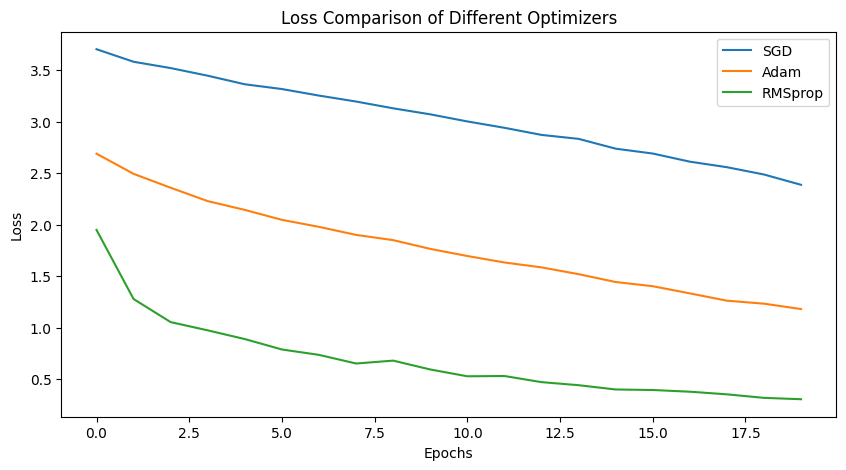

In [ ]:
import matplotlib.pyplot as plt

loss_results = {}
for name, opt in optimizers.items():
    print(f"\n🔹 使用 {name} 优化训练")
    loss_results[name] = train_and_evaluate(name, opt)

# **绘制 Loss 曲线**
plt.figure(figsize=(10, 5))
for name, loss_hist in loss_results.items():
    plt.plot(loss_hist, label=name)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Comparison of Different Optimizers")
plt.show()


In [58]:
def evaluate(model, test_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in test_loader:
            data = data.view(data.size(0), -1)
            output = model(data)
            _, predicted = torch.max(output, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    accuracy = correct / total * 100
    print(f"测试集准确率: {accuracy:.2f}%")
    return accuracy


In [57]:
for name, opt in optimizers.items():
    print(f"\n模型名称：{name}")
    evaluate(model, test_loader)



模型名称：SGD
📌 测试集准确率: 92.50%

模型名称：Adam
📌 测试集准确率: 92.50%

模型名称：RMSprop
📌 测试集准确率: 92.50%
